<a href="https://colab.research.google.com/github/HXY1029/DSS5104_GrpPrj/blob/main/energy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [14]:
#load the data energy_processed
import pandas as pd
file_path = '/content/drive/MyDrive/group/energy_processed.csv'
df = pd.read_csv(file_path)
df.head()

,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,...,Holiday_ID,holiday,school,hour,weekday,is_weekend,lag_1,lag_24,rolling_mean_3d,rolling_mean_7d
0,2015-01-10 00:00:00,949.5031,25.052789,0.017161,0.021683,20.918190,23.669977,0.016482,0.072174,11.894426,...,0,0,0,0,5,1,989.8507,977.2739,1093.533169,1092.047710
1,2015-01-10 01:00:00,906.9580,24.976495,0.017215,0.025253,21.335333,23.554620,0.016421,0.051376,12.485627,...,0,0,0,1,5,1,949.5031,943.6081,1093.067908,1091.670407
2,2015-01-10 02:00:00,863.5135,24.906274,0.017337,0.034378,22.177057,23.429712,0.016337,0.038712,12.949576,...,0,0,0,2,5,1,906.9580,917.0640,1092.441803,1091.380752
3,2015-01-10 03:00:00,848.4447,24.879724,0.017512,0.045349,22.742188,23.309412,0.016292,0.028526,13.091533,...,0,0,0,3,5,1,863.5135,895.9092,1091.913708,1091.072275
4,2015-01-10 04:00:00,839.8821,24.907922,0.017673,0.047501,22.630025,23.306360,0.016337,0.016182,13.050650,...,0,0,0,4,5,1,848.4447,885.2720,1091.406122,1090.774229


In [15]:
df.columns

Index(['datetime', 'nat_demand', 'T2M_toc', 'QV2M_toc', 'TQL_toc', 'W2M_toc',
       'T2M_san', 'QV2M_san', 'TQL_san', 'W2M_san', 'T2M_dav', 'QV2M_dav',
       'TQL_dav', 'W2M_dav', 'Holiday_ID', 'holiday', 'school', 'hour',
       'weekday', 'is_weekend', 'lag_1', 'lag_24', 'rolling_mean_3d',
       'rolling_mean_7d'],
      dtype='object')

In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# ------ 1. 设定列 ------
target_col = 'nat_demand'
feature_cols = [col for col in df.columns if col not in ['datetime', target_col]]

# ------ 2. 特征归一化 ------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[feature_cols])  # shape: (样本数, 特征数)

# ------ 3. 目标值归一化 ------
target_scaler = MinMaxScaler()
y_scaled = target_scaler.fit_transform(df[['nat_demand']]).flatten()


In [17]:
# ------ 4. 构造时间序列数据 ------
def create_sequences(X, y, seq_length=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_length=24)

# ------ 5. 划分训练集和测试集 ------
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)


In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    shuffle=False
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 35s 32ms/step - loss: 0.0349 - mae: 0.1301 - val_loss: 0.0027 - val_mae: 0.0371
Epoch 2/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - loss: 0.0046 - mae: 0.0534 - val_loss: 0.0024 - val_mae: 0.0359
Epoch 3/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 40s 31ms/step - loss: 0.0033 - mae: 0.0445 - val_loss: 0.0014 - val_mae: 0.0264
Epoch 4/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - loss: 0.0022 - mae: 0.0365 - val_loss: 0.0015 - val_mae: 0.0271
Epoch 5/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 30s 31ms/step - loss: 0.0016 - mae: 0.0303 - val_loss: 0.0013 - val_mae: 0.0245
Epoch 6/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 40s 31ms/step - loss: 0.0012 - mae: 0.0264 - val_loss: 0.0014 - val_mae: 0.0244
Epoch 7/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 29s 30ms/step - loss: 9.9822e-04 - mae: 0.0237 - val_loss: 0.0016 - val_mae: 0.0237
Epoch 8/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 40s 29ms/step - loss: 8.7993e-04 - mae: 0.0223 - val_loss: 0.0013 - val_mae: 0.0219
Epoch 9/20
958/958 ━━━━━━━━━━━━━

300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 5.8232e-04 - mae: 0.0170
Test MAE (scaled): 0.0226
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


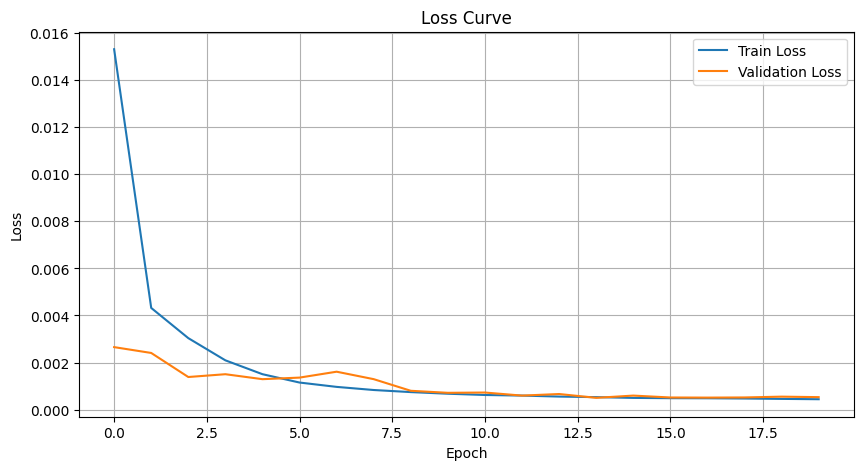

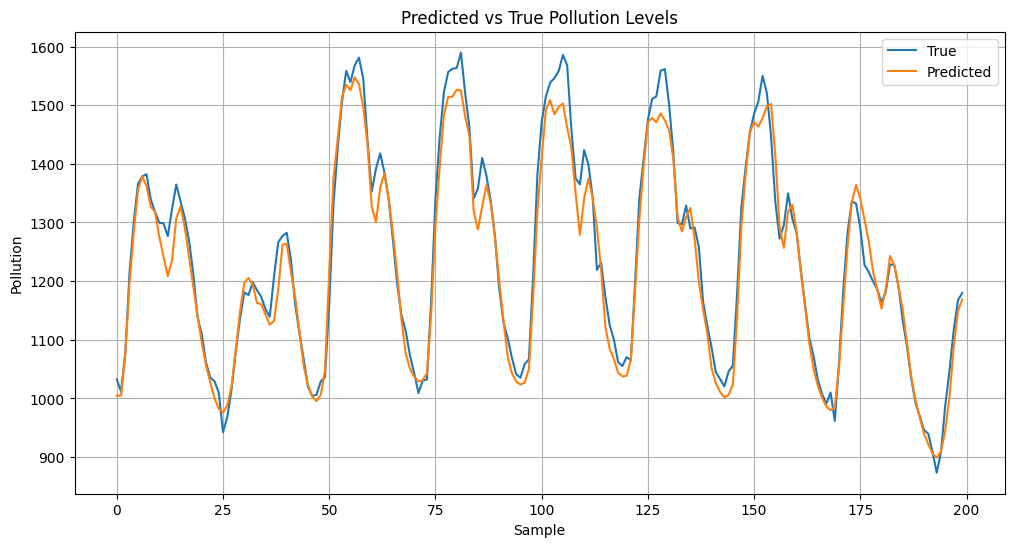

In [19]:
# 模型评估
loss, mae = model.evaluate(X_test, y_test)
print(f"Test MAE (scaled): {mae:.4f}")

# 反归一化预测值和真实值
y_pred_scaled = model.predict(X_test)
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_true = target_scaler.inverse_transform(y_test.reshape(-1, 1))

# 可视化 loss 曲线
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# 可视化预测 vs 真实
plt.figure(figsize=(12, 6))
plt.plot(y_true[:200], label='True')
plt.plot(y_pred[:200], label='Predicted')
plt.title('Predicted vs True Pollution Levels')
plt.xlabel('Sample')
plt.ylabel('Pollution')
plt.legend()
plt.grid(True)
plt.show()